<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/hypotension_prediction_using_art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hypotension prediction using arterial blood pressure waveform

In this sample code, we will try to build a machine learning based model for predicting hypotension (MBP < 65mmHg for more than 1 minute) from the arterial blood pressure waveform (ART) in the VitalDB dataset.

## Required libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

!pip install vitaldb
import vitaldb

## Case Selection

In [11]:
df_trks = pd.read_csv('https://api.vitaldb.net/trks')  # read track list
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # read case information

# inclusion & exclusion criteria
caseids = list(
    set(df_trks[df_trks['tname'] == 'SNUADC/ART']['caseid']) &
    set(df_cases[df_cases['age'] > 18]['caseid']) &
    set(df_cases[~df_cases['opname'].str.contains("transplant")]['caseid']) &
    set(df_cases[df_cases['age'] >= 18]['caseid']) & 
    set(df_cases[df_cases['weight'] >= 30]['caseid']) & 
    set(df_cases[df_cases['weight'] < 140]['caseid']) & 
    set(df_cases[df_cases['height'] >= 135]['caseid']) & 
    set(df_cases[df_cases['height'] < 200]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("heart")]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("cardiac")]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("transplant")]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("aneurysm")]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("aorto")]['caseid'])& 
    set(df_cases[df_cases['ane_type'] == 'General']['caseid'])
)
print('Total {} cases found'.format(len(caseids)))
np.random.shuffle(caseids)  # shuffle caseids

Total 3337 cases found


## Preprocessing

In this section, we will read the MBP data while iterating caseids. Only MAX_CASES (=100) cases will be used for to save time.

The arterial waveform data of each case will be read by passing the caseid into the vitaldb python library. Then, the pairs of x (input) and y (label) for training and validation of the model will be extracted.

In [20]:
MINUTES_AHEAD = 1  # Predict hypotension 1 minutes ahead
BATCH_SIZE = 256  # Batch size for learning
MAX_CASES = 100  # Maximum number of cases for this example
SRATE = 100  # sampling rate for the arterial waveform signal

# Final dataset for training and testing the model
x = []  # input with shape of (segements, timepoints)
y = []  # output with shape of (segments)
valid_mask = []  # validity of each segement
c = []  # caseid of each segment

# maximum number of cases
for caseid in caseids:
    print(f'loading {caseid}', end='...', flush=True)

    # read the arterial waveform
    arts = vitaldb.load_case(caseid, ['SNUADC/ART'], 1 / SRATE).flatten()

    # samples before arterial catheter inserted
    arts[arts < 30] = np.nan

    # removing the nan values at the beginning and the ending
    case_valid_mask = ~np.isnan(arts)
    arts = arts[(np.cumsum(case_valid_mask) > 0) & (np.cumsum(case_valid_mask[::-1])[::-1] > 0)]

    # input: 20sec - blackout: 1min - label: 1min
    case_sample = 0
    case_event = 0
    for i in range(0, len(arts) - SRATE * (20 + (1 + MINUTES_AHEAD) * 60), 10 * SRATE):
        segx = arts[i:i + SRATE * 20]
        segy = arts[i + SRATE * (20 + MINUTES_AHEAD * 60):i + SRATE * (20 + (1 + MINUTES_AHEAD) * 60)]

        # check the validity of this segment
        valid = True
        if np.isnan(segx).mean() > 0.1:
            valid = False
        elif np.isnan(segy).mean() > 0.1:
            valid = False
        elif (segx > 200).any():
            valid = False
        elif (segy > 200).any():
            valid = False
        elif np.max(segx) - np.min(segx) < 30:
            valid = False
        elif np.max(segy) - np.min(segy) < 30:
            valid = False
        elif (np.abs(np.diff(segx)) > 30).any():  # abrupt change -> noise
            valid = False
        elif (np.abs(np.diff(segy)) > 30).any():  # abrupt change -> noise
            valid = False

        n = 2 * SRATE  # 2 sec moving avg
        segy = np.nancumsum(segy, dtype=np.float32)
        segy[n:] = segy[n:] - segy[:-n]
        segy = segy[n - 1:] / n

        evt = np.nanmax(segy) < 65
        x.append(segx)
        y.append(evt)
        valid_mask.append(valid)
        c.append(caseid)
        
        if valid:
            case_sample += 1
            if evt:
                case_event += 1

    if case_sample > 0:
        print("{} samples {} ({:.1f} %) events".format(case_sample, case_event, 100*case_event/case_sample))
    else:
        print('no sample')

    if len(np.unique(c)) >= MAX_CASES:
        break

# final caseids
caseids = np.unique(c)

x = np.array(x)
y = np.array(y) 
valid_mask = np.array(valid_mask)
c = np.array(c)

# forward filling
x = pd.DataFrame(x).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

# normalization
x -= 65
x /= 65

x = x[...,None]  # add 3rd axis for input of CNN

print(x.shape)
print(y.shape)

loading 14...no sample
loading 22...1187 samples 0 (0.0 %) events
loading 66...754 samples 8 (1.1 %) events
loading 142...1138 samples 23 (2.0 %) events
loading 247...1910 samples 0 (0.0 %) events
loading 287...688 samples 2 (0.3 %) events
loading 326...no sample
loading 501...1135 samples 18 (1.6 %) events
loading 622...1262 samples 0 (0.0 %) events
loading 702...1579 samples 18 (1.1 %) events
loading 912...427 samples 0 (0.0 %) events
loading 980...2934 samples 0 (0.0 %) events
loading 1008...855 samples 0 (0.0 %) events
loading 1019...726 samples 0 (0.0 %) events
loading 1094...2550 samples 53 (2.1 %) events
loading 1109...938 samples 0 (0.0 %) events
loading 1196...426 samples 0 (0.0 %) events
loading 1264...585 samples 0 (0.0 %) events
loading 1439...690 samples 2 (0.3 %) events
loading 1493...1606 samples 19 (1.2 %) events
loading 1546...1266 samples 0 (0.0 %) events
loading 1620...1161 samples 8 (0.7 %) events
loading 1826...513 samples 7 (1.4 %) events
loading 1837...371 sample

## Splitting samples into training and testing dataset


In [21]:
ncase = len(caseids)
ntest = int(ncase * 0.2)
ntrain = ncase - ntest
caseids_train = caseids[:ntrain]
caseids_test = caseids[ncase - ntest:ncase]

# splitting into train set and test set
train_mask = np.isin(c, caseids_train)
test_mask = np.isin(c, caseids_test)

# invalid samples in test dataset is also needed for plotting
test_x = x[test_mask]
test_y = y[test_mask]
test_c = c[test_mask]

# only valid samples are required for the training dataset
train_x_valid = x[train_mask & valid_mask]
train_y_valid = y[train_mask & valid_mask]
test_x_valid = x[test_mask & valid_mask]
test_y_valid = y[test_mask & valid_mask]

testname = '{}cases {}ahead batchsize={} total {}, train {} ({} events {:.1f}%), test {} ({} events {:.1f}%)'.format(MAX_CASES, MINUTES_AHEAD, BATCH_SIZE, len(y), len(train_y_valid), sum(train_y_valid), 100*np.mean(train_y_valid), len(test_y_valid), sum(test_y_valid), 100*np.mean(test_y_valid))
testname

'100cases 1ahead batchsize=256 total 122437, train 75148 (1542 events 2.1%), test 24972 (2070 events 8.3%)'

## Model building and training

In [22]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

# making output folder
tempdir = 'output'
if not os.path.exists(tempdir):
    os.mkdir(tempdir)
weight_path = tempdir + "/weights.hdf5"

# hyper parameter
CNN_LAYERS = [64] * 6

# build a model
model = Sequential()
for num_node in CNN_LAYERS:
    model.add(Conv1D(filters=num_node, kernel_size=3, padding='valid'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D())
model.add(GlobalMaxPool1D())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])

hist = model.fit(train_x_valid, train_y_valid, validation_split=0.1, epochs=100, batch_size=BATCH_SIZE, class_weight={0:1, 1:5},
                 callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

# reload the best model
model.load_weights(weight_path)
open(tempdir + "/model.json", "wt").write(model.to_json())

Epoch 1/100
265/265 [==============================] - ETA: 0s - loss: 0.1664 - accuracy: 0.9607 - auc_1: 0.9494
Epoch 1: val_loss improved from inf to 0.09168, saving model to output/weights.hdf5
265/265 [==============================] - 29s 98ms/step - loss: 0.1664 - accuracy: 0.9607 - auc_1: 0.9494 - val_loss: 0.0917 - val_accuracy: 0.9697 - val_auc_1: 0.9628
Epoch 2/100
264/265 [============================>.] - ETA: 0s - loss: 0.1407 - accuracy: 0.9673 - auc_1: 0.9623
Epoch 2: val_loss improved from 0.09168 to 0.07656, saving model to output/weights.hdf5
265/265 [==============================] - 25s 94ms/step - loss: 0.1407 - accuracy: 0.9673 - auc_1: 0.9623 - val_loss: 0.0766 - val_accuracy: 0.9718 - val_auc_1: 0.9634
Epoch 3/100
264/265 [============================>.] - ETA: 0s - loss: 0.1363 - accuracy: 0.9675 - auc_1: 0.9653
Epoch 3: val_loss did not improve from 0.07656
265/265 [==============================] - 24s 92ms/step - loss: 0.1362 - accuracy: 0.9676 - auc_1: 0.96

9312

## Evaluation of the model performance

In [23]:
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve

# make prediction on the test dataset
test_y_pred = model.predict(test_x_valid, BATCH_SIZE).flatten()

precision, recall, thmbps = precision_recall_curve(test_y_valid, test_y_pred)
auprc = auc(recall, precision)

fpr, tpr, thmbps = roc_curve(test_y_valid, test_y_pred)
auroc = auc(fpr, tpr)

thval = 0.5
f1 = f1_score(test_y_valid, test_y_pred > thval)
acc = accuracy_score(test_y_valid, test_y_pred > thval)
tn, fp, fn, tp = confusion_matrix(test_y_valid, test_y_pred > thval).ravel()

testres = 'auroc={:.3f}, auprc={:.3f} acc={:.3f}, F1={:.3f}, PPV={:.1f}, NPV={:.1f}, TN={}, fp={}, fn={}, TP={}'.format(auroc, auprc, acc, f1, tp/(tp+fp)*100, tn/(tn+fn)*100, tn, fp, fn, tp)
print(testres)

# rename final output folder
odir = testname + ' ' + testres
os.rename(tempdir, odir)

# auroc curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('{}/auroc.png'.format(odir))
plt.close()

# auprc curve
plt.figure(figsize=(10, 10))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('{}/auprc.png'.format(odir))
plt.close()

auroc=0.965, auprc=0.663 acc=0.938, F1=0.528, PPV=70.8, NPV=95.0, TN=22543, fp=359, fn=1198, TP=872


## Plotting each case in the test dataset

5309	0.007221816875213488	


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


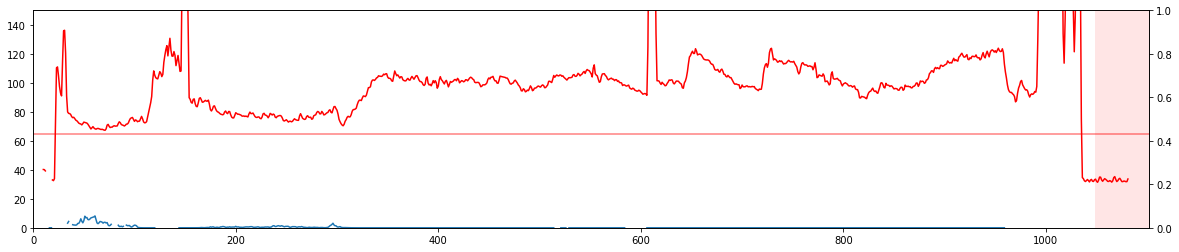

5478	0.20226460496005055	


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


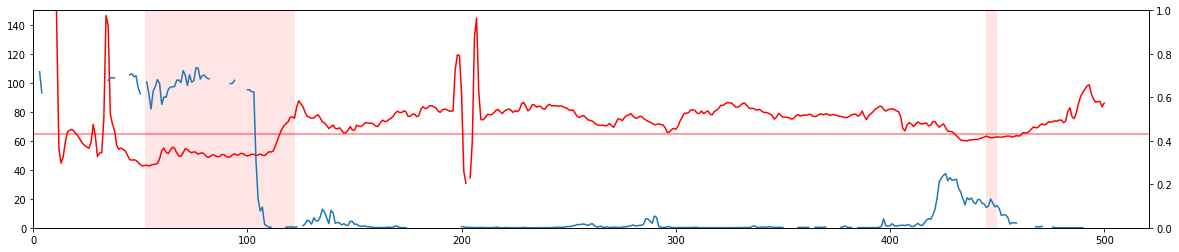

5511	0.06139332773653102	


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


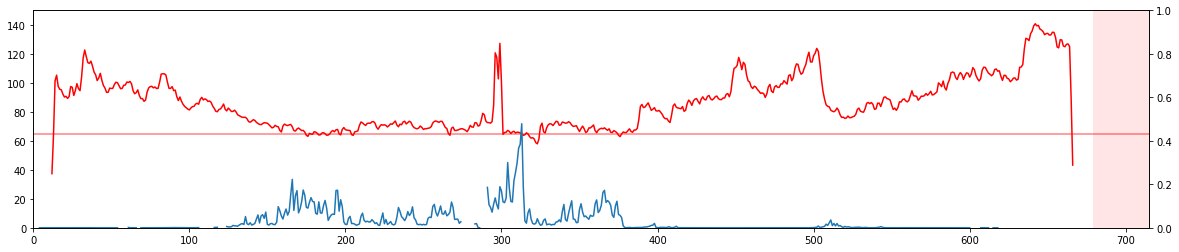

5516	0.22680819277853326	


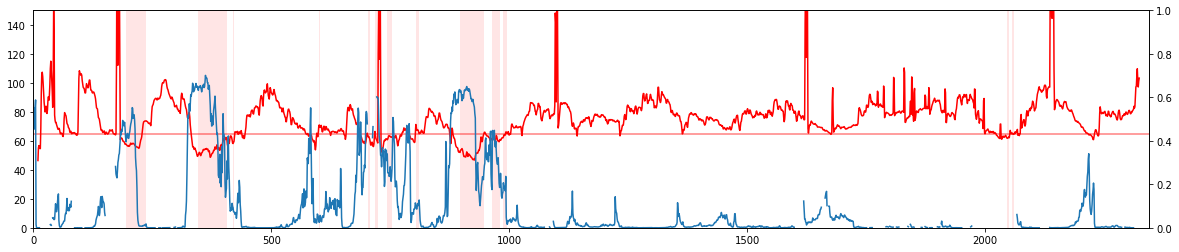

5538	0.2851422188847197	


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


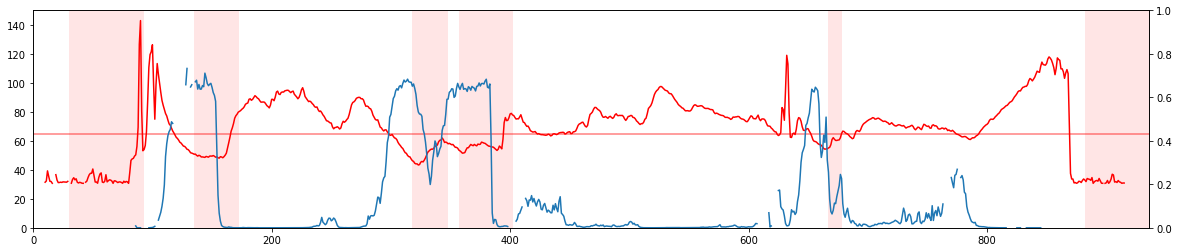

5601	0.2022296815970236	


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


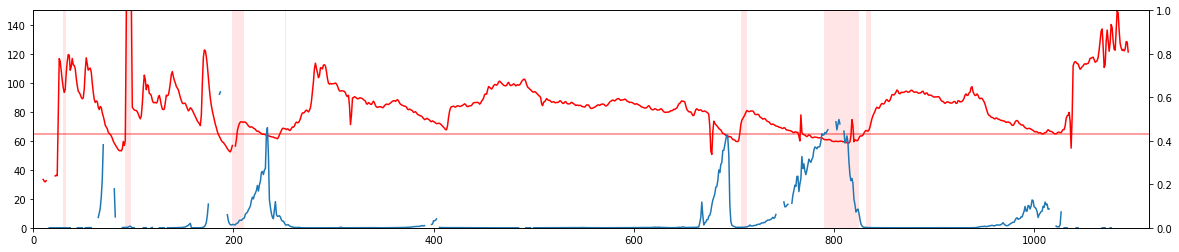

5603	0.06739006832696864	


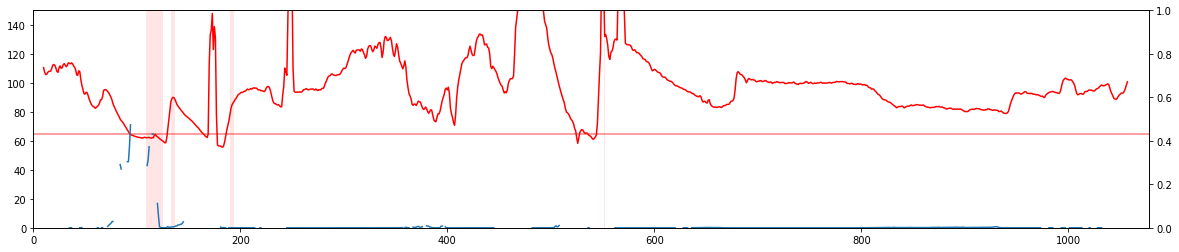

5610	0.04648517149154699	


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


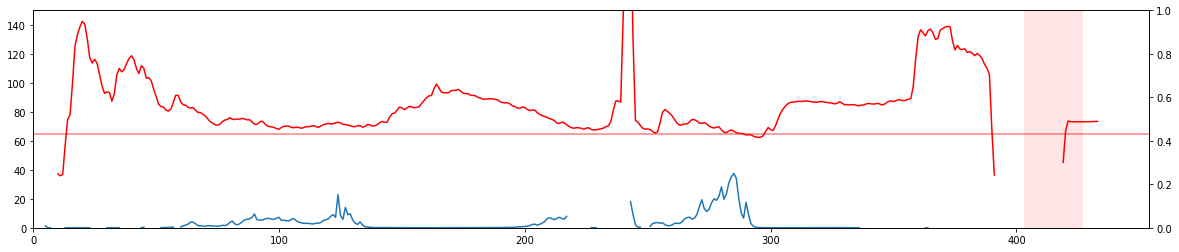

5633	0.3125652483533439	


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


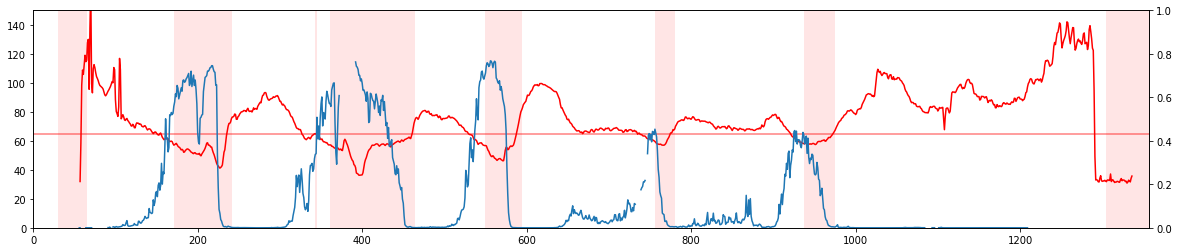

5641	0.10108059480615515	


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


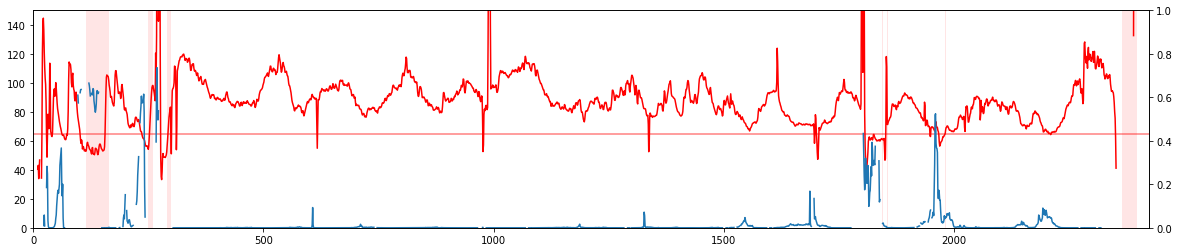

5751	0.14734030835854045	


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


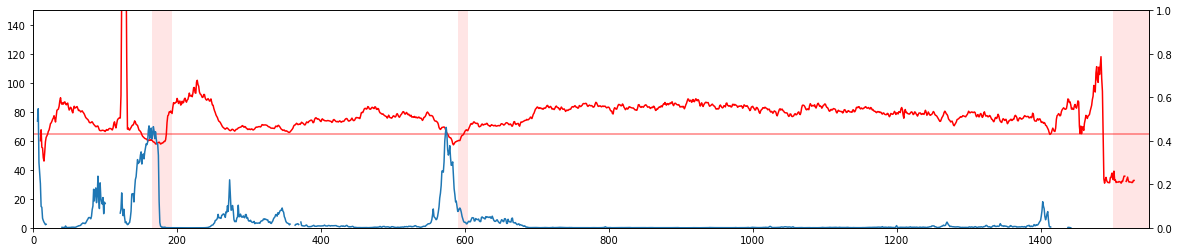

5787	0.29304011429402127	


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


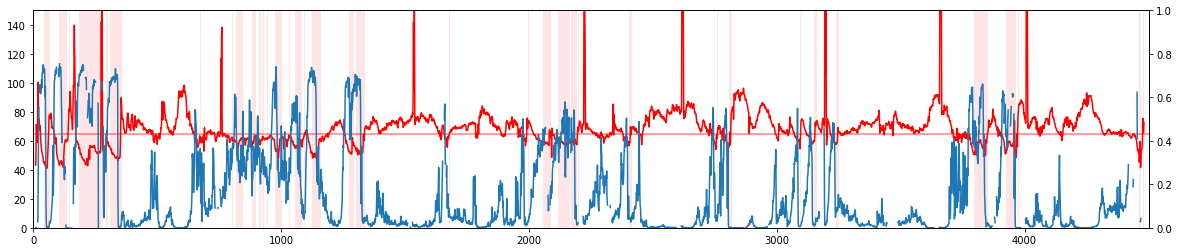

5844	0.03809774655883186	


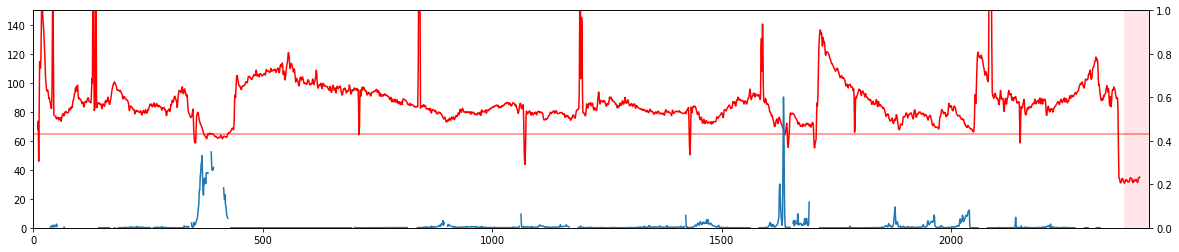

5871	0.0017133485017978625	


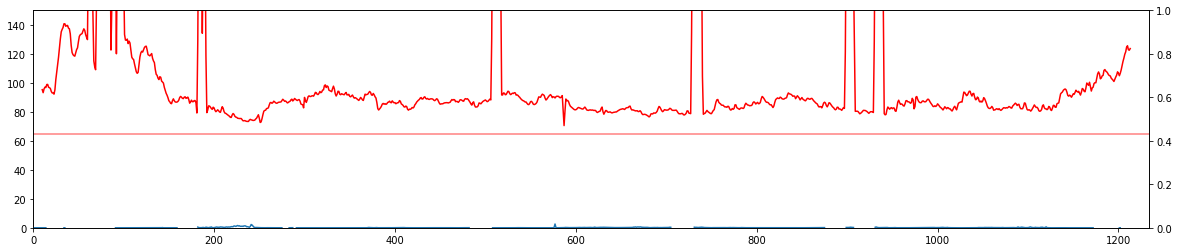

5993	0.30160944726402905	


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


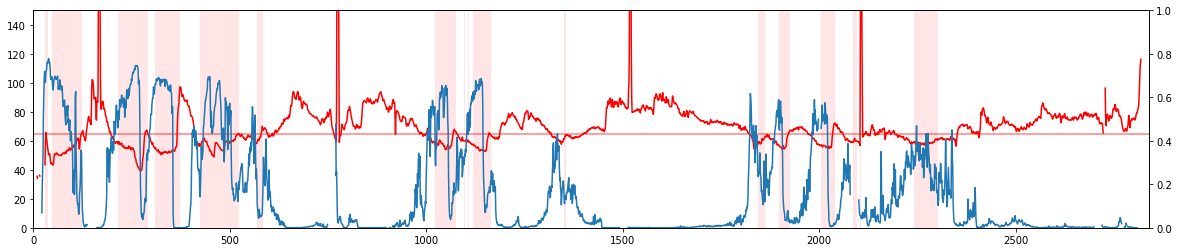

6013	0.32865040584996474	


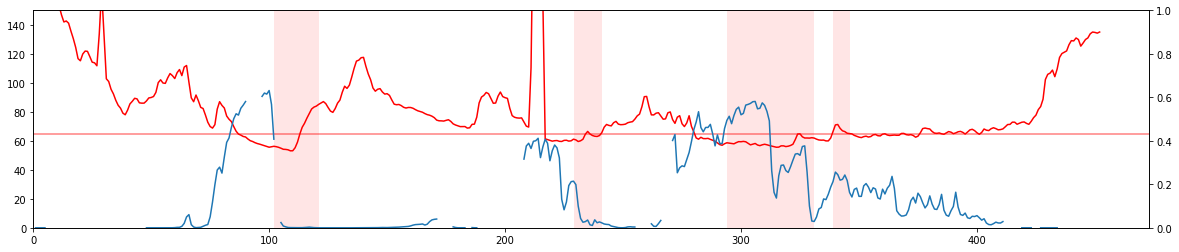

6028	0.14332289374484145	


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


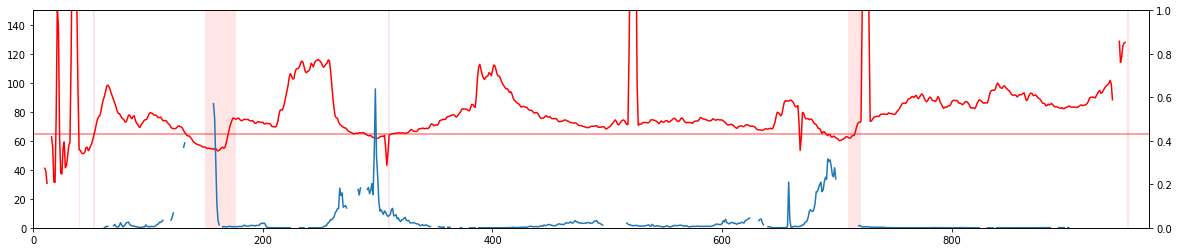

6289	0.039019244802189046	


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


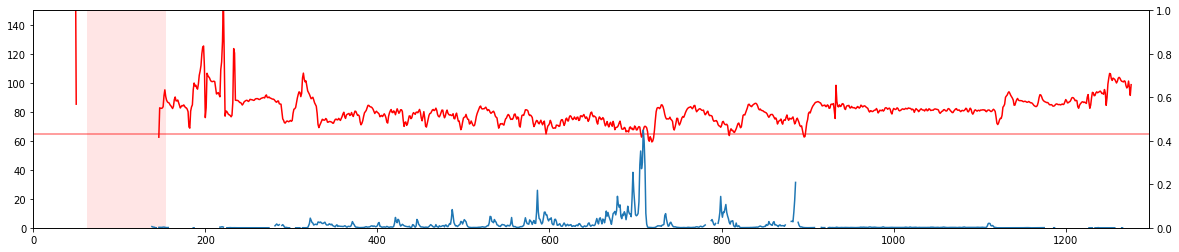

6335	0.018488278883041852	


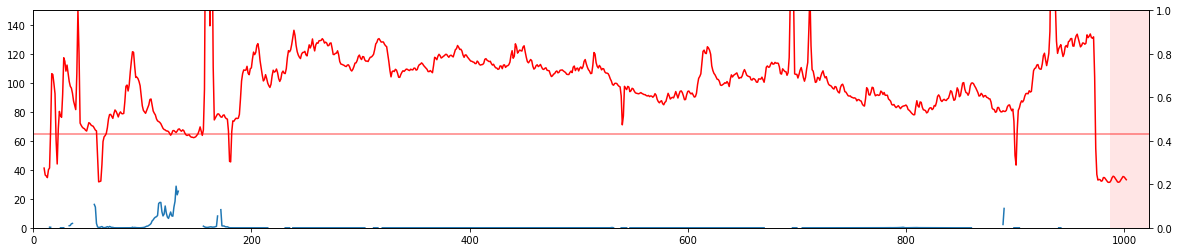

6386	0.022337633369850958	


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


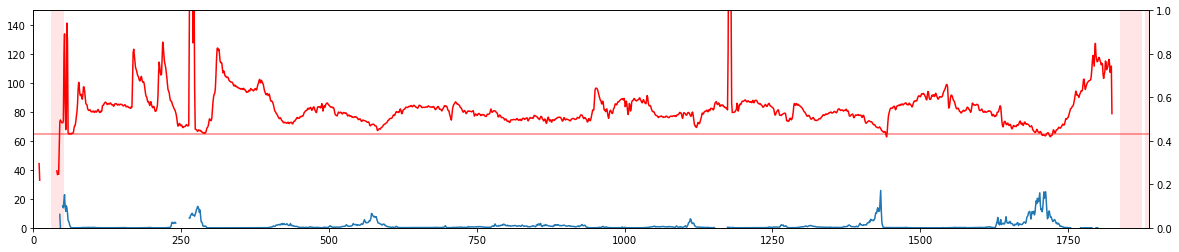

In [24]:
for caseid in caseids_test:
    case_mask = (test_c == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    case_x = test_x[case_mask]
    case_y = test_y[case_mask]
    case_p = model.predict(case_x).flatten()
    case_valid_mask = valid_mask[test_mask][case_mask]
    
    # calculate error for this case
    case_rmse = np.nanmean(np.square(case_y[case_valid_mask] - case_p[case_valid_mask])) ** 0.5
    print('{}\t{}\t'.format(caseid, case_rmse))

    # draw
    plt.figure(figsize=(20, 4))
    plt.xlim([0, case_len + MINUTES_AHEAD * 30])
    t = np.arange(0, case_len)

    # red bars for the event
    ax1 = plt.gca()
    for i in range(len(case_y)):
        if case_y[i]:
            ax1.axvspan(i + MINUTES_AHEAD * 30, i + MINUTES_AHEAD * 30 + 1, color='r', alpha=0.1, lw=0)

    # 65 mmHg bar
    ax1.axhline(y=65, color='r', alpha=0.5)
    ax1.plot(t + 10, np.nanmean(test_x[case_mask], axis=1) * 65 + 65, color='r')
    ax1.set_ylim([0, 150])

    ax2 = ax1.twinx()
    
    # draw valid samples
    case_p[~case_valid_mask] = np.nan
    ax2.plot(t, case_p)
    ax2.set_ylim([0, 1])
    
    # save
    plt.show()